# Event Finder

The goal of this notebook is to develop a generalized event finder. Based on user selected variable and event definitions, this notebook will search all simulations to find these events. 
Inputs:

* Domain,a custom shapefile
* One variable
* Low and/or High thresholds
* Duration 
* GWL

## Make Selections

Before running this notebook, make the following selections for variables, domain, and GWLs.

1. Select a timescale - this will impact which downscaling methods are available and which variables are availble.

In [1]:
timescale = "daily" # options are hourly, daily or monthly

2. Select a variable - the code below displays which variables are available based on your timescale options

In [2]:
# import function 
from climakitae.explore.agnostic import (
  show_available_vars
)

In [3]:
# display variables available for this analysis 
# only showing dynamical because statistical has a smaller subset that is in the larger dynamical subset
# only difference is max/min RH is availble in statistical and not in dynamical 
show_available_vars("Dynamical",timescale)

['Air Temperature at 2m',
 'Precipitation (total)',
 'Relative humidity',
 'Dew point temperature',
 'Mean wind speed at 10m',
 'Maximum wind speed at 10m',
 'Surface Pressure',
 'Specific humidity at 2m',
 'Surface skin temperature',
 'Maximum air temperature at 2m',
 'Minimum air temperature at 2m',
 'Instantaneous downwelling longwave flux at bottom',
 'Instantaneous downwelling shortwave flux at bottom',
 'Shortwave flux at the surface',
 'Longwave flux at the surface',
 'Sensible heat flux at the surface',
 'Latent heat flux at the surface',
 'Ground heat flux',
 'Snowfall',
 'Liquid water path',
 'Evaporation',
 'Ice water path',
 'Maximum precipitation',
 'Effective Temperature']

In [4]:
# make selection from list above
event_variable = "Precipitation (total)"
event_units = "inches"

3. Define Event - Select a method for establishing the event

In [5]:
# define the function that will be used to calculate the event threshold
event_threshold_function="1 in x" # options are "percentile" or "1 in x" 
event_threshold_direction = ">" # look for events above or below the result from the threshold funciton
event_threshold_function_params = 10 # if 1 in X include X, if quantile, include quantile (0.25, 0.5, etc.)
event_duration = 1 # how many consecuvitve events need to be observed to be a hit 

4. Select a baseline and future GWL

In [6]:
# current options 0.8, 1.0, 1.2, 1.5, 2.0, 2.5, 3.0, 4.0
baseline_gwl = "1.0"
future_gwl = "2.0"

5. Select Spatial Domain - provide a shapefile to clip data to

In [7]:
# edit path below and filename for shapefile to use
shapefile_filename = 'PajaroRiverWatershed.zip'
spatial_domian = "Pajaro" # name will appear in title

6. Select Resolution - select the the model resolution (3km, 9km, 45 km)

In [8]:
resolution = "3 km"

7. Aggregation Method - select a method to aggregate spatially

In [9]:
aggregation = "median" # options are mean, median, sum, min, max

## Import libraries & define functions

In [10]:
import climakitae as ck 
from climakitae.core.data_interface import (
    get_data_options, 
    get_subsetting_options, 
    get_data
)
from climakitae.util.utils import add_dummy_time_to_wl
from climakitae.explore import threshold_tools
from climakitae.explore.threshold_tools import get_block_maxima, get_return_value, get_return_period

import xarray as xr
import pandas as pd
import geopandas as gpd
from shapely.geometry import mapping
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

In [11]:
def clip_to_shapefile(da, shapefile):
    """
    Clip a DataArray to the boundaries of a shapefile.

    Parameters:
    - da: xarray DataArray to be clipped
    - shapefile: path to the shapefile

    Returns:
    - Clipped DataArray
    """
    # Read the shapefile using geopandas
    gdf = gpd.read_file(shapefile)

    # Ensure the DataArray has a CRS set
    #da.rio.write_crs("epsg:2228", inplace=True)

    # Clip the DataArray using the shapefile geometry
    clipped_da = da.rio.clip(gdf.geometry.apply(mapping), gdf.crs, drop=True)

    return clipped_da

## Step 1: Define Event 

Use the baseline GWL to define the event threshold

### Pull Baseline Data

#### Dynamical Downscaling (wrf)

In [12]:
# WRF downscaling
wrf_data =get_data(
        variable = event_variable, 
        downscaling_method = "Dynamical", 
        resolution = resolution, 
        timescale = timescale, 
        units = event_units,
        # Modify your approach 
        approach = "Warming Level",
        warming_level= float(baseline_gwl),
    )

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!! Returned data array is huge. Operations could take 10x to infinity longer than 1GB of data !!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!



In [13]:
# rename lat lon
wrf_data=wrf_data.rename({'x': 'longitude','y': 'latitude'})

In [14]:
# add a dummy time variable
wrf_data = add_dummy_time_to_wl(wrf_data)

#### Statistical Downscaling (loca2)

In [15]:
# grab correct variable name for loca 2 
loca_variable = [event_variable]
# temperature
if loca_variable[0] == "Air Temperature at 2m":
    loca_variable = ["Maximum air temperature at 2m", "Minimum air temperature at 2m"]
# relative humidity
if loca_variable[0] == "Relative humidity":
    loca_variable = ["Minimum relative humidity", "Maximum relative humidity"]

In [16]:
# statistical - loca2 downscaling xvariable
loca_data = [get_data(
        variable = GETVAR, 
        downscaling_method = "Statistical", 
        resolution = resolution, 
        units = event_units,
        timescale = timescale,
        # Modify your approach 
        approach = "Warming Level",
        warming_level= float(baseline_gwl),
    ) for GETVAR in loca_variable]

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!! Returned data array is huge. Operations could take 10x to infinity longer than 1GB of data !!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!



In [17]:
# if we need to average 
if loca_data[0] is not None:
    # temperature
    if event_variable == "Air Temperature at 2m":
        loca_data = (loca_data[0] + loca_data[1]) / 2
        loca_data.name = "Air Temperature at 2m"
        
    # relative humidity
    if event_variable == "Relative humidity":
        loca_data = (loca_data[0] + loca_data[1]) / 2
        loca_data.name = "Relative humidity"

In [18]:
# unlist if needed
if type(loca_data) == list:
    loca_data = loca_data[0]

# now merge
# first check if there is valid loca data - requires that both x and y have valid data
if loca_data is None:
    # set to wrf
    loca_data = wrf_data
    # replace with all NaNs
    loca_data = loca_data*np.nan
else:
    loca_data=loca_data.rename({'lon': 'longitude','lat': 'latitude'})
# add a dummy time variable
loca_data = add_dummy_time_to_wl(loca_data)

### Downsize Data

In [19]:
# clip to shapefile
wrf_data = clip_to_shapefile(wrf_data, shapefile_filename)
loca_data = clip_to_shapefile(loca_data, shapefile_filename)

In [20]:
# average across domain (we want single timeseries)
wrf_data = eval(f"wrf_data.{aggregation}(['longitude','latitude'])")
loca_data = eval(f"loca_data.{aggregation}(['longitude','latitude'])")

### Import Data

In [21]:
loca_data = loca_data.compute().squeeze()
wrf_data = wrf_data.compute().squeeze()

### Define Event

In [22]:
# determine what method to define event
if event_threshold_function == "percentile":
    # calculate the percentile 
    loca_threshold = loca_data.quantile(dim="time",q=event_threshold_function_params).squeeze()
    wrf_threshold = wrf_data.quantile(dim="time",q=event_threshold_function_params).squeeze()
# if 1 in x
if event_threshold_function == "1 in x":
    if event_threshold_direction == ">":
        extreme_type = "max"
    else:
        extreme_type = "min"
    # intalize
    loca_list = []
    for sim in loca_data.simulation:
        loca_ams = get_block_maxima(
            loca_data.sel({"simulation":sim}),
            check_ess=True,
            extremes_type = extreme_type,
        )
        loca_rv = get_return_value(loca_ams,return_period = event_threshold_function_params,multiple_points=False)
        loca_rv = loca_rv.expand_dims(dim="simulation")
        loca_list.append(loca_rv)
    loca_threshold = xr.concat(loca_list,loca_data.simulation)
    loca_threshold = loca_threshold["return_value"].squeeze()
    # intalize
    wrf_list = []
    for sim in wrf_data.simulation:
        wrf_ams = get_block_maxima(
            wrf_data.sel({"simulation":sim}),
            check_ess=True,
            extremes_type = extreme_type,
        )
        wrf_rv = get_return_value(wrf_ams,return_period = event_threshold_function_params,multiple_points=False)
        wrf_rv = wrf_rv.expand_dims(dim="simulation")
        wrf_list.append(wrf_rv)
    wrf_threshold = xr.concat(wrf_list,wrf_data.simulation)
    wrf_threshold = wrf_threshold["return_value"].squeeze()

Dropping 5 block maxima NaNs across entire Precipitation (total) DataArray. Please guidance for more information. 
Dropping 5 block maxima NaNs across entire Precipitation (total) DataArray. Please guidance for more information. 
Dropping 1 block maxima NaNs across entire Precipitation (total) DataArray. Please guidance for more information. 
Dropping 2 block maxima NaNs across entire Precipitation (total) DataArray. Please guidance for more information. 
Dropping 2 block maxima NaNs across entire Precipitation (total) DataArray. Please guidance for more information. 
Dropping 2 block maxima NaNs across entire Precipitation (total) DataArray. Please guidance for more information. 
Dropping 2 block maxima NaNs across entire Precipitation (total) DataArray. Please guidance for more information. 
Dropping 8 block maxima NaNs across entire Precipitation (total) DataArray. Please guidance for more information. 


In [23]:
# remove baseline data to free up memory
del loca_data
del wrf_data

## Step 2: Estimate Event 'Hits'

Use the fugure GWL to estimate event hits

### Pull Future GWL Data

#### Dynamical Downscaling (wrf)

In [24]:
# WRF downscaling
wrf_data =get_data(
        variable = event_variable, 
        downscaling_method = "Dynamical", 
        resolution = resolution, 
        timescale = timescale, 
        units = event_units,
        # Modify your approach 
        approach = "Warming Level",
        warming_level= float(future_gwl),
    )

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!! Returned data array is huge. Operations could take 10x to infinity longer than 1GB of data !!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!



In [25]:
# rename lat lon
wrf_data=wrf_data.rename({'x': 'longitude','y': 'latitude'})

In [26]:
# add a dummy time variable
wrf_data = add_dummy_time_to_wl(wrf_data)

#### Statistical Downscaling (loca2)

In [27]:
# grab correct variable name for loca 2 
loca_variable = [event_variable]
# temperature
if loca_variable[0] == "Air Temperature at 2m":
    loca_variable = ["Maximum air temperature at 2m", "Minimum air temperature at 2m"]
# relative humidity
if loca_variable[0] == "Relative humidity":
    loca_variable = ["Minimum relative humidity", "Maximum relative humidity"]

In [28]:
# statistical - loca2 downscaling xvariable
loca_data = [get_data(
        variable = GETVAR, 
        downscaling_method = "Statistical", 
        resolution = resolution, 
        units = event_units,
        timescale = timescale,
        # Modify your approach 
        approach = "Warming Level",
        warming_level= float(future_gwl),
    ) for GETVAR in loca_variable]

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!! Returned data array is huge. Operations could take 10x to infinity longer than 1GB of data !!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!



In [29]:
# if we need to average 
if loca_data[0] is not None:
    # temperature
    if event_variable == "Air Temperature at 2m":
        loca_data = (loca_data[0] + loca_data[1]) / 2
        loca_data.name = "Air Temperature at 2m"
        
    # relative humidity
    if event_variable == "Relative humidity":
        loca_data = (loca_data[0] + loca_data[1]) / 2
        loca_data.name = "Relative humidity"

In [30]:
# unlist if needed
if type(loca_data) == list:
    loca_data = loca_data[0]

# now merge
# first check if there is valid loca data - requires that both x and y have valid data
if loca_data is None:
    # set to wrf
    loca_data = wrf_data
    # replace with all NaNs
    loca_data = loca_data*np.nan
else:
    loca_data=loca_data.rename({'lon': 'longitude','lat': 'latitude'})
# add a dummy time variable
loca_data = add_dummy_time_to_wl(loca_data)

### Downsize Data

In [31]:
# clip to shapefile
wrf_data = clip_to_shapefile(wrf_data, shapefile_filename)
loca_data = clip_to_shapefile(loca_data, shapefile_filename)

In [32]:
# average across domain (we want single timeseries)
wrf_data = eval(f"wrf_data.{aggregation}(['longitude','latitude'])")
loca_data = eval(f"loca_data.{aggregation}(['longitude','latitude'])")

### Import Data

In [33]:
loca_data = loca_data.compute().squeeze()
wrf_data = wrf_data.compute().squeeze()

### Count Hits

In [34]:
### create a 'hit' for in events
# intialize an array to fill
wrfEventHit = np.zeros(wrf_data.values.shape)
locaEventHit = np.zeros(loca_data.values.shape)

# loop through each time stamp
for itime in range(0,len(wrf_data["time"])):
    # look at this time stamp + duration 
    timeIndex = list(range(itime,(itime+event_duration)))
    # remove any values that are greater than our time
    timeIndex = [x for x in timeIndex if x < len(wrf_data["time"])]

    ### Start with WRF
    # pull out the data to test
    testWRFData = wrf_data[timeIndex,:]
    
    # for each simulation, check if the values are greater or less than the threshold 
    if event_threshold_direction == "<":
        wrfCounts = (testWRFData < wrf_threshold).sum(dim="time")
    if event_threshold_direction == ">":
        wrfCounts = (testWRFData > wrf_threshold).sum(dim="time")

    # if you have greater than or equal to duration count as a 'hit'
    wrfHitIndex = (wrfCounts >= event_duration)

    # now save hits
    wrfEventHit[itime,wrfHitIndex]  = 1 

    ### Move to Loca
    # pull out the data to test
    testLOCAData = loca_data[timeIndex,:]
    
    # for each simulation, check if the values are greater or less than the threshold 
    if event_threshold_direction == "<":
        locaCounts = (testLOCAData < loca_threshold).sum(dim="time")
    if event_threshold_direction == ">":
        locaCounts = (testLOCAData > loca_threshold).sum(dim="time")

    # if you have greater than or equal to duration count as a 'hit'
    locaHitIndex = (locaCounts >= event_duration)

    # now save hits
    locaEventHit[itime,locaHitIndex]  = 1 

In [35]:
# now add hits to xarray as a new 
wrf_data = wrf_data.to_dataset()
wrf_data = wrf_data.assign(event_hit=(("time","simulation"),wrfEventHit))
loca_data = loca_data.to_dataset()
loca_data = loca_data.assign(event_hit=(("time","simulation"),locaEventHit))

## Prep for Plotting

In [36]:
# create a 'model' variable
lsims=loca_data.simulation.values.tolist()
loca_models = [s.split("_")[1] for s in lsims]
loca_data = loca_data.assign_coords(models = ("simulation",loca_models))

In [37]:
wsims=wrf_data.simulation.values.tolist()
wrf_models = [s.split("_")[1] for s in wsims]
wrf_data = wrf_data.assign_coords(models = ("simulation",wrf_models))

In [38]:
# create a data frame to make plotting easier
locaDF = loca_data.to_dataframe().reset_index()
wrfDF = wrf_data.to_dataframe().reset_index()

In [39]:
# Create a downscaling name
locaDF["downscaling"] = "loca2"
wrfDF["downscaling"] = "wrf"

In [40]:
# combine into one 
finalDF = pd.concat([locaDF, wrfDF],keys=locaDF.keys())

## Step 3: Plot Results (Yay!)

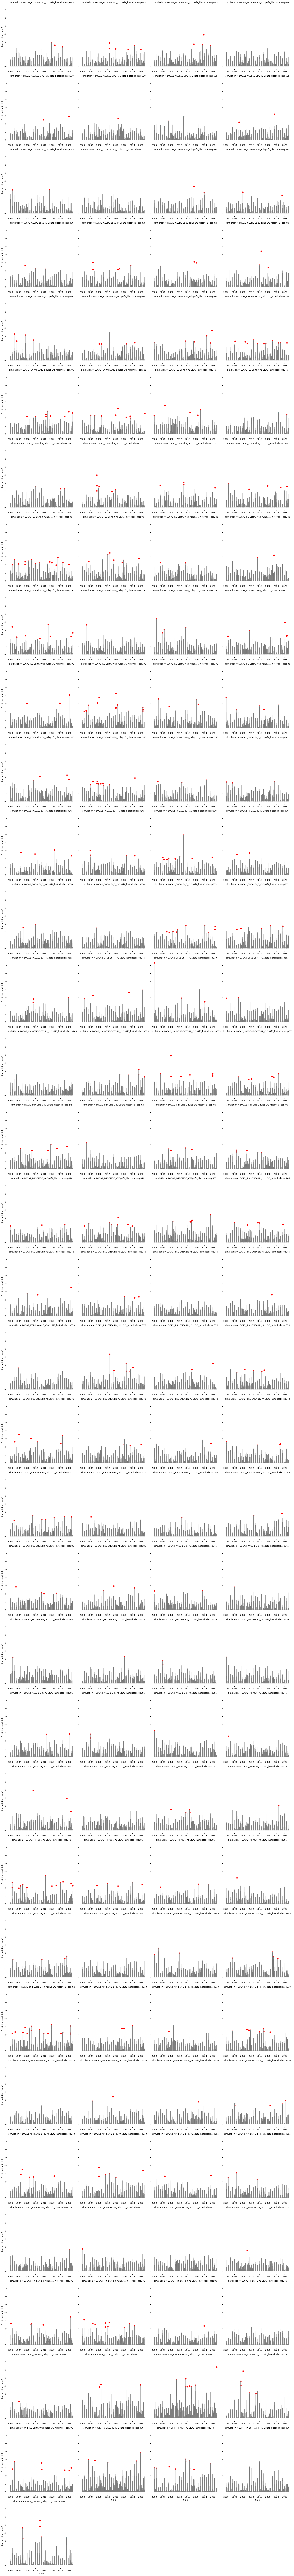

In [41]:
# plot all the data 
# plot all the data 
def annotate(data, **kws):
    ax = plt.gca()
    ax.scatter(data.time.where(data.event_hit == 1),data[event_variable].where(data.event_hit == 1),color='r')
g1 = sns.relplot(
    data=finalDF,
    x="time", y=event_variable,
    col="simulation",color="grey",col_wrap=4,
    kind="line", 
    height=5, aspect=1, facet_kws=dict(sharex=False), 
)
g1.map_dataframe(annotate)

In [42]:
# create a directory for saving everything, if it does not exist already
folder_path = "event_finder"  # Replace with your desired folder path

try:
    os.makedirs(folder_path, exist_ok=True)
    print(f"Folder '{folder_path}' created successfully or already exists.")
except OSError as e:
    print(f"Error creating folder '{folder_path}': {e}")

Folder 'event_finder' created successfully or already exists.


In [43]:
# Save the figure to a file
if event_threshold_function == "1 in x":
    event_name = f'1_in_{event_threshold_function_params}'
else: 
    event_name = event_threshold_function_params+"_percentile"
g1.savefig(f'event_finder/event_finder_{event_variable}_under_{future_gwl}gwl_with_{event_name}_{event_duration}{timescale}duration.jpeg'.replace(" ", "_"))

In [44]:
# add a variable called 'wrf' and 'loca2' into the data
wrf_data["downscaling"] = "wrf"
loca_data["downscaling"] = "loca2"

In [45]:
# concat
final = xr.concat([loca_data,wrf_data],dim="simulation",
                         coords="minimal",compat='override')

In [46]:
# save event data
final.to_netcdf(f'event_finder/event_{event_variable}_under_{future_gwl}gwl_with_{event_name}_{event_duration}{timescale}duration.nc'.replace(" ", "_"))